## Raspagem de dados do site TOTALCORNER e montando o DataFrame

In [86]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import cloudscraper

#Raspagem de dados to site TOTALCORNER
def get_corner_stats(team_id:str,is_home:bool='all'):
    scraper = cloudscraper.create_scraper()
    n_pages = 2
    first_half_corners_for = []
    second_half_corners_for = []
    match_corners_for = []
    first_half_corners_against = []
    second_half_corners_against = []
    match_corners_against = []
    total_match_corners = []
    total_first_half_corners = []
    total_second_half_corners =[]
    home_or_away = []
    corners_balance =[]
    against = []
    team_name = ''

    for page in range(1,n_pages + 1):
        time.sleep(1)

        html = scraper.get(f'https://www.totalcorner.com/team/view/{team_id}/page:{page}').content

        soup = BeautifulSoup(html, 'html.parser')
        if not soup.find("meta", {"name":"description"}):
            print('CAPTCHA')
            break
        if team_name == '':
            team_name = soup.find("meta", {"name":"description"})["content"]
            team_name = team_name.split(",")[0].replace('Team: ','')
        



        table_rows = soup.findAll("tr")
        for rows in table_rows:
            #Ignorando jogos que ainda não aconteceram
            if rows.find("span", class_="span_half_corner hide"):
                continue
            match = rows.find("td", class_="match_home")
            #Pegando nome do time que joga em casa
            if match != None:
                home_team = match.find('a').text
            #Ignorando possiveis linhas que não são referente a partidas
            else:
                continue
            match = rows.find("td", class_="match_away")
            #Pegando nome do time que joga fora de casa
            if match != None:
                away_team = match.find('a').text
            #Pegando dados sobre escanteios
            half_corners = rows.find("span", class_="span_half_corner").text
            match_corners = rows.find("span", class_="span_match_corner").text
            home_half_corners = half_corners.replace('(','').replace(')','').split('-')[0]
            away_half_corners = half_corners.replace('(','').replace(')','').split('-')[1]
            home_match_corners = match_corners.split(' ')[0]
            away_match_corners = match_corners.split(' ')[-1]
            home_second_half_corners = int(home_match_corners) - int(home_half_corners)
            away_second_half_corners = int(away_match_corners) - int(away_half_corners)
            #Organizando dados para o dataframe
            if home_team == team_name:
                against.append(away_team)            
                balance = int(home_match_corners) - int(away_match_corners)
                first_half_corners_for.append(int(home_half_corners))
                second_half_corners_for.append(int(home_second_half_corners))
                match_corners_for.append(int(home_match_corners))
                first_half_corners_against.append(int(away_half_corners))
                second_half_corners_against.append(int(away_second_half_corners))
                match_corners_against.append(int(away_match_corners))
                total_match_corners.append(int(home_match_corners) + int(away_match_corners))
                total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
                total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
                home_or_away.append('Home')
                corners_balance.append(balance)

            else:
                against.append(home_team)  
                balance = int(away_match_corners) - int(home_match_corners)
                first_half_corners_for.append(int(away_half_corners))
                second_half_corners_for.append(int(away_second_half_corners))
                match_corners_for.append(int(away_match_corners))
                first_half_corners_against.append(int(home_half_corners))
                second_half_corners_against.append(int(home_second_half_corners))
                match_corners_against.append(int(home_match_corners))
                total_match_corners.append(int(home_match_corners) + int(away_match_corners))
                total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
                total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
                home_or_away.append('Away')
                corners_balance.append(balance)
    #Criando DataFrame
    df = pd.DataFrame(list(zip(
            first_half_corners_for,
            second_half_corners_for,
            match_corners_for,
            first_half_corners_against,
            second_half_corners_against,
            match_corners_against,
            total_match_corners,
            total_first_half_corners,
            total_second_half_corners,
            home_or_away,
            corners_balance,
            against
        )),
        columns=[
            'first_half_corners_for',
            'second_half_corners_for',
            'match_corners_for',
            'first_half_corners_against',
            'second_half_corners_against',
            'match_corners_against',
            'total_match_corners',
            'total_first_half_corners',
            'total_second_half_corners',
            'home_or_away',
            'corners_balance',
            'against'

        ])
    if is_home == 'all':
        return (team_name, df)
    if is_home:
        return (team_name, df[(df.home_or_away == "Home")])
    else:
        return (team_name, df[(df.home_or_away == "Away")])


### Criando relátorio com fairlines de escanteios para as principais partidas de hoje

In [56]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import datetime


def get_fairlines(corner_lines_range,home_corner_series,away_corner_series,over_or_under,ft_or_1h):
    fairlines = {}
    if over_or_under.lower() == 'over':
        for corner in corner_lines_range:
                #Percentual de partidas com MAIS de X escanteios
                home = (home_corner_series > corner).mean()
                away = (away_corner_series > corner).mean()
                if home == 0 or away == 0:
                    home = 9999
                else:
                    home = round(1/home,2)
                    away = round(1/away,2)
                fairlines[f'{ft_or_1h}_over_{corner}.5'] = max(home,away)
    else:
        for corner in corner_lines_range:
                #Percentual de partidas com MENOS de X escanteios
                home = (home_corner_series < corner).mean()
                away = (away_corner_series < corner).mean()
                if home == 0 or away == 0:
                    home = 9999
                else:
                    home = round(1/home,2)
                    away = round(1/away,2)
                fairlines[f'{ft_or_1h}_under_{corner - 1 }.5'] = max(home,away)
    return fairlines



def generate_report():
    desired_leagues = ["France Ligue 1",'Portugal Primeira Liga','Netherlands Eredivisie','	Spain Primera Liga','Spain Segunda','Italy Serie B',
                       'England Championship','England Premier League','Germany Bundesliga I','Italy Serie A','Colombia Primera A','Uruguay Apertura',
                        'Chile Primera Division','Argentina Liga Profesional','USA MLS','Paraguay Division Profesional',
                       'Venezuela Primera Division','Mexico Liga MX','Japan J-League','Germany Bundesliga II','UEFA Champions League',
                       'Copa do Brasil','Copa Libertadores','Copa Sudamericana','UEFA Europa League','Brazil Serie A',
                       'Argentina Liga Profesional','Germany DFB Pokal']
    result = []
    html = requests.get('https://www.totalcorner.com/match/today').content
    soup = BeautifulSoup(html, 'html.parser')
    date = soup.select('h3 > small')[0].text
    pages = 2
    if soup.find('ul',{'class':'pagination'}):
        pages = len(soup.find('ul',{'class':'pagination'}).findChildren('li', recursive=False))
    pagination_url = [''] + [f'page:{i}' for i in range(2,pages)]
    print(pagination_url)
    for page in pagination_url:
        html = requests.get(f'https://www.totalcorner.com/match/today/{page}').content
        soup = BeautifulSoup(html, 'html.parser')
        table_rows = soup.find_all("tr")
        #Lendo as linhas da tabela
        for rows in table_rows:
            game = {}
            minutes = rows.find('span', class_="match_status_minutes")
            #ignorando linhas que não tem a coluna de tempo da partida
            if not minutes:
                continue
            #ignorando partidas que já começaram
            if minutes.text == "":
                links = rows.find_all('a', href=True)
                league = links[0].text
                #Filtrando ligas
                if league not in desired_leagues:
                    continue
                #Pegando ID dos times
                home_team_id = links[1]['href'].split('/')[-1]
                away_team_id = links[2]['href'].split('/')[-1]
                #Pegando os dados de escanteios dos times.
                home_team_name, df_home = get_corner_stats(home_team_id,True)
                time.sleep(1)
                away_team_name, df_away = get_corner_stats(away_team_id,False)
                #Encerra o loop caso o site peça CAPTCHA
                if not (home_team_name and away_team_name):
                    break
                else:
                    game['Name'] = f'{home_team_name} X {away_team_name}'
                    #Percentual de partidas com saldo de escanteios positivos e negativos
                    home_balance = round((df_home.corners_balance > 0).mean()*100)
                    negative_home_balance = round((df_home.corners_balance < 0).mean()*100)
                    away_balance = round((df_away.corners_balance > 0).mean()*100)
                    negative_away_balance = round((df_away.corners_balance < 0).mean()*100)
                    #Definindo linhas de over e under escanteios para analise
                    first_half_over_range = range(1,6)
                    first_half_under_range = range(7,4,-1)
                    full_time_over_range = range(6,13)
                    full_time_under_range = range(12,8,-1)

                    print(f'{home_team_name} X {away_team_name}')
                    game.update(get_fairlines(first_half_over_range,df_home.total_first_half_corners,df_away.total_first_half_corners,'over','1H'))
                    game.update(get_fairlines(first_half_under_range,df_home.total_first_half_corners,df_away.total_first_half_corners,'under','1H'))
                    game.update(get_fairlines(full_time_over_range,df_home.total_match_corners,df_away.total_match_corners,'over','FT'))
                    game.update(get_fairlines(full_time_under_range,df_home.total_match_corners,df_away.total_match_corners,'under','FT'))
                    result.append(game)

                    balance_dif = home_balance - away_balance 
                    if abs(balance_dif) >= 40:
                        if(home_balance > away_balance):
                            fair = 1/((home_balance + negative_away_balance)/200)
                            game.update({'most_corners':home_team_name,'most_corners_fairline':fair})
                        else:
                            fair = 1/((negative_home_balance + away_balance)/200)
                            game.update({'most_corners':home_team_name,'most_corners_fairline':fair})
                    else:
                        game.update({'most_corners':'-','most_corners_fairline':'-'})
    result_df = pd.DataFrame.from_records(result)
    try:
        with pd.ExcelWriter(f'fairlines{datetime.date.today() + datetime.timedelta(days=1)}.xlsx',mode='a',engine="openpyxl",if_sheet_exists='replace') as writer:
            result_df.to_excel(writer, index=False,sheet_name='Fairlines')
    except:
        with pd.ExcelWriter(f'fairlines{datetime.date.today() + datetime.timedelta(days=1)}.xlsx',mode='w',engine="openpyxl") as writer:
            result_df.to_excel(writer, index=False,sheet_name='Fairlines')
      



generate_report()

['']
Consadole Sapporo X Kashima Antlers
Kyoto Sanga FC X Kawasaki Frontale
Gamba Osaka X Cerezo Osaka
Shonan Bellmare X Kashiwa Reysol
Nagoya Grampus X Vissel Kobe
Avispa Fukuoka X FC Tokyo
Sagan Tosu X Yokohama F-Marinos
Yokohama FC X Albirex Niigata
Atalanta X Spezia
Juventus X Lecce
Sampdoria X Torino
Salernitana X Fiorentina
VfB Stuttgart X Eintracht Frankfurt
Liverpool X Fulham
Man City X West Ham
Verona X Inter Milan
Lazio X Sassuolo
Monza X Roma
AC Milan X Cremonese
Brest X Nantes
Palestino X San Lorenzo
Internacional X Nacional De Football
Cerro Porteno X Bolivar
Guarani Asuncion X Emelec
Academia Puerto Cabello X CA Tigre
Millonarios X America MG
Colo Colo X Boca Juniors
Atletico Mineiro X Alianza Lima
Barcelona Guayaquil X Palmeiras
Independiente Medellin X Metropolitanos FC


### Pegando odds da Betano

In [57]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By


def get_odds(search_term):
    try:
        print('Getting odds for', search_term)
        url = "https://br.betano.com/" 
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')
        options.add_argument('--window-size=1920x1080')
        driver = webdriver.Chrome(options=options)
        driver.get(url) 
        
        # Garantindo que a pagina foi carregada
        time.sleep(2)
        #Fechando popup inicial
        close_modal = driver.find_element(By.CLASS_NAME,'sb-modal__close__btn')
        close_modal.click()
        #clicando no icone de busca
        search = driver.find_element(By.CLASS_NAME,'sb-header__header__actions__search-icon')
        search.click()
        time.sleep(1)
        #Digitando confronto no input de busca
        driver.find_element(By.CLASS_NAME,'uk-input').send_keys(search_term)
        time.sleep(3)
        if len(driver.find_elements(By.CLASS_NAME,'search-modal__empty-state')) != 0:
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(Keys.CONTROL + "a")
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(Keys.DELETE)
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(search_term.split('X')[0])
            time.sleep(3)
        #Caso não seja encontrado retorna um objeto com o nome do confronto
        if len(driver.find_elements(By.CLASS_NAME,'search-modal__empty-state')) != 0:
            print('Jogo Não encontrado')
            return {'Name':search_term}
        #Caso encontrado clica no primeiro resultado
        else:
            if len(driver.find_elements(By.CLASS_NAME,'search-result')) == 0:
                time.sleep(4)
            driver.find_element(By.CLASS_NAME,'search-result').click()
            time.sleep(5)
            #Procura categoria escanteio e clica nela
            categories = driver.find_elements(By.CLASS_NAME,'GTM-tab-name')
            for category in categories:
                if 'escanteios' in category.get_attribute("innerHTML").lower():
                    category.click()
                    time.sleep(2)
            #passa o html estatico para o beautiful soup
            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")
            #Pega todos os mercados de escanteios
            corner_markets = soup.find_all('div',class_='markets__market__header__title')
            market_titles = ['Name']
            market_odds = [search_term]
            #Filtra apenas os mercados de interesse (FT Mais/Menos e HT Mais/Menos)
            #Armazena as odds e o nome do mercado em uma lista cada.
            for market in corner_markets:
                if 'Escanteios' in market.text.split()[0] and 'Mais/Menos' in market.text.split()[1]:
                    parent_tag = market.parent.parent
                    titles = parent_tag.find_all('span',class_='selections__selection__title')
                    odds = parent_tag.find_all('span',class_='selections__selection__odd')
                    market_titles = market_titles + [title.text.replace('Mais de','FT_over_').replace('Menos de','FT_under_') for title in titles]
                    market_odds = market_odds + [odd.text.split()[0] for odd in odds]
                if 'Mais/Menos' in market.text.split()[0] and '1' in market.text.split()[1]:
                    parent_tag = market.parent.parent
                    titles = parent_tag.find_all('span',class_='selections__selection__title')
                    odds = parent_tag.find_all('span',class_='selections__selection__odd')
                    market_titles = market_titles + [title.text.replace('Mais de','1H_over_').replace('Menos de','1H_under_') for title in titles]
                    market_odds = market_odds + [odd.text.split()[0] for odd in odds]
            print('Odds Found !')        
            return dict(zip(market_titles,market_odds))
    except Exception as e:
        print('Error getting odds',str(e))
        return {'Name':search_term}
        

        


### Preenchendo planilha com ODDS betano

In [58]:
#Lê a planilha com as fairlines criadas
df_fairlines = pd.read_excel(f'fairlines{datetime.date.today() + datetime.timedelta(days=1)}.xlsx')
odds_result = []
#Para cada jogo busca as odds na betano
for game in list(df_fairlines.Name):
    odds_result.append(get_odds(game))
#Cria um dataframe com as odds
odds_df = pd.DataFrame.from_records(odds_result)
display(odds_df.head(2))



Getting odds for Consadole Sapporo X Kashima Antlers
Odds Found !
Getting odds for Kyoto Sanga FC X Kawasaki Frontale
Odds Found !
Getting odds for Gamba Osaka X Cerezo Osaka
Odds Found !
Getting odds for Shonan Bellmare X Kashiwa Reysol
Odds Found !
Getting odds for Nagoya Grampus X Vissel Kobe
Odds Found !
Getting odds for Avispa Fukuoka X FC Tokyo
Odds Found !
Getting odds for Sagan Tosu X Yokohama F-Marinos
Odds Found !
Getting odds for Yokohama FC X Albirex Niigata
Odds Found !
Getting odds for Atalanta X Spezia
Odds Found !
Getting odds for Juventus X Lecce
Odds Found !
Getting odds for Sampdoria X Torino
Odds Found !
Getting odds for Salernitana X Fiorentina
Odds Found !
Getting odds for VfB Stuttgart X Eintracht Frankfurt
Odds Found !
Getting odds for Liverpool X Fulham
Odds Found !
Getting odds for Man City X West Ham
Odds Found !
Getting odds for Verona X Inter Milan
Odds Found !
Getting odds for Lazio X Sassuolo
Odds Found !
Getting odds for Monza X Roma
Odds Found !
Getting

,Name,FT_over_9.5,FT_under_9.5,1H_over_4.5,1H_under_4.5,FT_over_7.5,FT_under_7.5,FT_over_8.5,FT_under_8.5,FT_over_10.5,...,1H_over_1.5,1H_under_1.5,1H_over_7.5,1H_under_7.5,1H_over_8.5,1H_under_8.5,1H_over_9.5,1H_under_9.5,FT_over_18.5,FT_under_18.5
0,Consadole Sapporo X Kashima Antlers,2.07,1.70,2.05,1.72,1.37,2.95,1.65,2.15,2.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kyoto Sanga FC X Kawasaki Frontale,2.07,1.70,2.05,1.72,1.36,3.00,1.62,2.20,2.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gamba Osaka X Cerezo Osaka,2.07,1.70,2.05,1.72,1.36,3.00,1.65,2.15,2.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Shonan Bellmare X Kashiwa Reysol,1.78,1.98,1.82,1.91,1.26,3.65,1.45,2.60,2.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nagoya Grampus X Vissel Kobe,1.93,1.82,1.93,1.80,1.31,3.25,1.55,2.35,2.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Avispa Fukuoka X FC Tokyo,2.15,1.65,2.07,1.70,1.39,2.85,1.70,2.07,2.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Sagan Tosu X Yokohama F-Marinos,1.93,1.82,1.93,1.82,1.31,3.25,1.55,2.35,2.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Yokohama FC X Albirex Niigata,2.02,1.75,2.00,1.75,1.35,3.05,1.62,2.22,2.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Atalanta X Spezia,1.83,1.91,1.87,1.87,1.28,3.50,1.50,2.50,2.35,...,1.04,9.00,6.50,1.09,9.25,1.04,12.00,1.01,NaN,NaN
9,Juventus X Lecce,1.88,1.85,1.91,1.83,1.30,3.35,1.53,2.40,2.45,...,1.04,9.00,6.70,1.09,9.75,1.03,12.00,1.01,NaN,NaN


### Limpando e organizando os dataframes de ODDS e Fairlines para compará-los e encontrar oportunidades

In [59]:
df_fairlines = pd.read_excel(f'fairlines{datetime.date.today()  + datetime.timedelta(days=1)}.xlsx')
odds_df = pd.DataFrame.from_records(odds_result)
#Removendo colunas de odds que não tenham fairlines calculadas
for column in odds_df.columns:
    if column not in df_fairlines.columns:
        odds_df.drop(column,inplace=True, axis='columns')
#Removendo colunas com mercados especiais
df_fairlines.drop(['most_corners','most_corners_fairline'],axis='columns',inplace=True)
#Reordenando as colunas
cols = list(odds_df.columns)
cols.pop(0)
sorted_cols = sorted(cols)
sorted_cols.insert(0,'Name')
odds_df = odds_df[sorted_cols]
df_fairlines = df_fairlines[sorted_cols]
#Removendo linhas que não foram encontradas odds na betano
df_fairlines = df_fairlines[df_fairlines.Name.isin(odds_df.Name)]
df_fairlines.reset_index(inplace=True,drop=True)
#Criando novo dataframe com a diferença entre fairline e odds
diff = pd.DataFrame()
df_fairlines.iloc[:,1:] = df_fairlines.iloc[:,1:].astype(float)
odds_df.iloc[:,1:] = odds_df.iloc[:,1:].astype(float)
diff['Name']= df_fairlines.Name
diff = pd.concat([diff, df_fairlines.iloc[:,1:] - odds_df.iloc[:,1:]],axis=1)
display(diff.head(2))



,Name,1H_over_1.5,1H_over_2.5,1H_over_3.5,1H_over_4.5,1H_over_5.5,1H_under_4.5,1H_under_5.5,1H_under_6.5,FT_over_10.5,FT_over_11.5,FT_over_12.5,FT_over_6.5,FT_over_7.5,FT_over_8.5,FT_over_9.5,FT_under_10.5,FT_under_11.5,FT_under_8.5,FT_under_9.5
0,Consadole Sapporo X Kashima Antlers,NaN,0.18,0.34,0.84,1.78,0.09,-0.05,0.02,0.5,0.39,NaN,NaN,0.36,0.35,0.57,0.03,0.12,0.27,0.16
1,Kyoto Sanga FC X Kawasaki Frontale,NaN,0.1,0.46,0.95,1.45,0.53,0.07,0.01,9996.28,9995.3,NaN,NaN,0.33,0.63,1.79,0.08,-0.02,-0.27,-0.2
2,Gamba Osaka X Cerezo Osaka,NaN,0.1,0.46,1.81,0.81,0.28,0.21,0.06,-0.39,0.8,NaN,NaN,0.29,0.35,0.08,0.38,0.22,-0.07,0.23
3,Shonan Bellmare X Kashiwa Reysol,NaN,0.27,1.07,0.98,2.78,-0.32,-0.18,-0.05,0.45,2.4,NaN,NaN,0.43,0.63,0.47,0.15,-0.03,0.9,0.57
4,Nagoya Grampus X Vissel Kobe,NaN,0.27,0.56,0.96,0.4,-0.09,0.11,0.19,0.39,0.36,NaN,NaN,0.55,0.81,0.43,0.5,0.31,0.65,0.36
5,Avispa Fukuoka X FC Tokyo,NaN,0.36,1.05,0.73,2.85,0.06,-0.06,-0.03,3.15,6.05,NaN,NaN,0.26,0.18,1.6,0.01,0.17,0.08,0.35
6,Sagan Tosu X Yokohama F-Marinos,NaN,0.7,0.89,0.87,1.15,0.41,0.68,0.03,1.0,1.48,NaN,NaN,0.56,0.6,1.18,0.11,0.04,0.87,0.6
7,Yokohama FC X Albirex Niigata,NaN,0.14,0.74,1.1,0.88,0.06,0.09,0.09,-0.07,0.02,NaN,NaN,0.18,0.1,0.05,0.27,0.15,0.2,0.32
8,Atalanta X Spezia,0.0,0.1,0.22,0.49,1.61,-0.08,0.05,0.12,1.36,1.85,4.03,0.16,0.45,0.36,0.53,0.01,-0.03,0.62,0.01
9,Juventus X Lecce,0.23,0.17,0.14,0.24,1.87,0.17,-0.07,-0.02,3.15,2.3,4.83,0.17,0.17,0.12,0.45,-0.12,-0.09,0.4,0.3


In [65]:
def get_odds(row):
    return odds_df.loc[odds_df["Name"] == row['Jogo']][row['Market']].values[0]
#Criando dataFrame onde fairline - odd(betano) < -0.14,
#  ou seja betano está pagando mais do que consideramos justo
oportunities = diff[diff.loc[:,'1H_over_1.5':] < -0.14]
#Removendo valores ausentes
oportunities.dropna(axis=0,how='all',inplace=True)
oportunities.dropna(axis=1,how='all',inplace=True)
#Pegando novamente o nome dos confrontos
oportunities = oportunities.merge(odds_df['Name'],left_index=True,right_index=True,how='inner')
oportunities.set_index("Name",inplace=True)
#Transformando as oportunidades em uma lista de entradas
oportunities = oportunities.stack().reset_index().set_axis(['Jogo', 'Market', 'Margem'], axis=1, inplace=False)
#Buscando as odds das oportunidades
oportunities['Odd'] = oportunities.apply(get_odds, axis=1 )
oportunities['Probabilidade'] = oportunities.apply(lambda x: 1/(x['Margem']+x['Odd']), axis=1 )
oportunities['Criada_em'] = datetime.date.today()
oportunities['Resultado'] = np.nan
display(oportunities)





,Jogo,Market,Margem,Odd,Probabilidade,Criada_em,Resultado
0,Kyoto Sanga FC X Kawasaki Frontale,FT_under_8.5,-0.27,2.20,0.518135,2023-05-02,
1,Kyoto Sanga FC X Kawasaki Frontale,FT_under_9.5,-0.2,1.70,0.666667,2023-05-02,
2,Gamba Osaka X Cerezo Osaka,FT_over_10.5,-0.39,2.72,0.429185,2023-05-02,
3,Shonan Bellmare X Kashiwa Reysol,1H_under_4.5,-0.32,1.91,0.628931,2023-05-02,
4,Shonan Bellmare X Kashiwa Reysol,1H_under_5.5,-0.18,1.45,0.787402,2023-05-02,
5,Liverpool X Fulham,1H_under_4.5,-0.24,2.05,0.552486,2023-05-02,
6,Liverpool X Fulham,1H_under_5.5,-0.2,1.52,0.757576,2023-05-02,
7,Liverpool X Fulham,FT_under_11.5,-0.19,1.45,0.793651,2023-05-02,
8,Liverpool X Fulham,FT_under_8.5,-0.31,2.95,0.378788,2023-05-02,
9,Liverpool X Fulham,FT_under_9.5,-0.49,2.20,0.584795,2023-05-02,


#### Updating Excel

In [61]:
with pd.ExcelWriter(f'fairlines{datetime.date.today() + datetime.timedelta(days=1)}.xlsx',mode='a',engine="openpyxl",if_sheet_exists='replace') as writer:
    odds_df.to_excel(writer, sheet_name='betano_odds', index=False)
    diff.to_excel(writer,sheet_name="Fair - Betano", index=False)
with pd.ExcelWriter(f'oportunities.xlsx',mode='a',engine="openpyxl",if_sheet_exists='overlay') as writer:
    oportunities.to_excel(writer, sheet_name="Oportunidades",index=False,startrow=writer.sheets['Oportunidades'].max_row,header=None)

#### Consolidando planilhas oportunidades

In [85]:
#import os
#path = os.getcwd()
#files = os.listdir(path)
#xlsx_files = [ file for file in files if (file[-5:] == '.xlsx' and file[0] == 'f') ]
#df_oportunities = pd.DataFrame(columns=['Jogo','Market','Margem','Odd','Probabilidade','Criada_em','Resultado'])
#for file in xlsx_files:
#    read_xlsx = pd.read_excel(f'{file}', sheet_name='Oportunidades',engine="openpyxl")
#    read_xlsx['Criada_em'] = file[9:-5]
#    df_oportunities = pd.concat([df_oportunities, read_xlsx], ignore_index=True)
#display(df_oportunities)
#with pd.ExcelWriter(f'oportunities.xlsx',mode='w',engine="openpyxl") as writer:
#    df_oportunities.to_excel(writer, sheet_name="Oportunidades",index=False)


#### Lendo planilha de oportunidades

In [121]:
results_df = pd.read_excel('oportunities.xlsx', sheet_name='Oportunidades',engine="openpyxl")
print('Lucro apostando 1u em todas oportunidades com probabilidade...')
p_range = np.arange(start = 0.1,stop=0.95,step=0.05)
for probability in p_range:
    profit = results_df[results_df['Probabilidade'] >= probability]['Resultado'].sum()
    entries = results_df[results_df['Probabilidade'] >= probability]['Resultado'].count()
    acertos = results_df[(results_df['Resultado'] > 0) & (results_df['Probabilidade'] >= probability)]['Resultado'].count()
    print(f'>= a {round(probability*100)}% : {round(profit,2)}u ({acertos} acertos de {entries} entradas {round(acertos/entries*100,1)}%)')


Lucro apostando 1u em todas oportunidades com probabilidade...
>= a 10% : -11.42u (41 acertos de 97 entradas 42.3%)
>= a 15% : -11.42u (41 acertos de 97 entradas 42.3%)
>= a 20% : -10.42u (41 acertos de 96 entradas 42.7%)
>= a 25% : -9.42u (41 acertos de 95 entradas 43.2%)
>= a 30% : -13.82u (39 acertos de 91 entradas 42.9%)
>= a 35% : -13.02u (38 acertos de 87 entradas 43.7%)
>= a 40% : -9.79u (36 acertos de 77 entradas 46.8%)
>= a 45% : -5.46u (34 acertos de 66 entradas 51.5%)
>= a 50% : 0.25u (31 acertos de 53 entradas 58.5%)
>= a 55% : 0.81u (28 acertos de 46 entradas 60.9%)
>= a 60% : -0.18u (22 acertos de 35 entradas 62.9%)
>= a 65% : 2.08u (19 acertos de 27 entradas 70.4%)
>= a 70% : 5.67u (17 acertos de 20 entradas 85.0%)
>= a 75% : 3.92u (11 acertos de 12 entradas 91.7%)
>= a 80% : 2.71u (8 acertos de 8 entradas 100.0%)
>= a 85% : 1.61u (5 acertos de 5 entradas 100.0%)
>= a 90% : 0.59u (2 acertos de 2 entradas 100.0%)


#### Mercados mais lucrativos

In [112]:
results_df.groupby(['Market'])['Resultado'].sum().sort_values(ascending=False)

Market
1H_over_5.5      4.58
FT_under_9.5     2.78
1H_over_3.5      1.41
FT_over_12.5     1.40
FT_under_11.5    0.04
1H_over_4.5     -0.30
FT_over_9.5     -1.00
FT_under_10.5   -1.50
1H_under_5.5    -2.85
1H_under_4.5    -3.77
FT_over_11.5    -3.80
FT_over_10.5    -4.00
FT_under_8.5    -4.41
Name: Resultado, dtype: float64

### Relátorio teste confronto entre duas equipes

Arsenal Jogando em casa


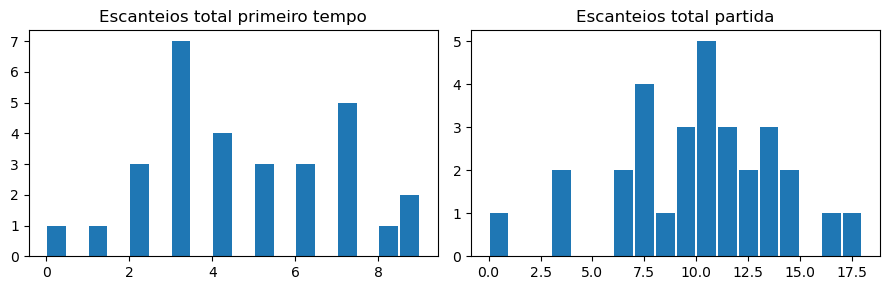

 PRIMEIRO TEMPO: 
1H 85% das partidas - de 7.5 escanteios
1H 85% das partidas + de  1.5 escanteios
1H partidas com menos de 6.5  73 % Fairline: 1.36
1H partidas com menos de 5.5  63 % Fairline: 1.58
1H partidas com menos de 4.5  53 % Fairline: 1.88
1H partidas com mais de 1.5  93 % Fairline: 1.07
1H partidas com mais de 2.5  83 % Fairline: 1.2
1H partidas com mais de 3.5  60 % Fairline: 1.67
JOGO COMPLETO: 
FT 85% das partidas - de  13.5 escanteios
FT 85% das partidas + de  5.5 escanteios
FT partidas com menos de 10.5  60 % Fairline: 1.67
FT partidas com menos de 9.5  43 % Fairline: 2.31
FT partidas com menos de 8.5  33 % Fairline: 3.0
FT partidas com mais de 6.5  83 % Fairline: 1.2
FT partidas com mais de 7.5  70 % Fairline: 1.43
FT partidas com mais de 8.5  67 % Fairline: 1.5
Partidas com saldo de escanteios positivo:  80 %
Partidas com saldo de escanteios negativo:  13 %
Partidas escanteios empatados:  7 %
Média escanteios por partida:  10
desvio padrão:  4


,first_half_corners_for,second_half_corners_for,match_corners_for,first_half_corners_against,second_half_corners_against,match_corners_against,total_match_corners,total_first_half_corners,total_second_half_corners,home_or_away,corners_balance,against
0,2,5,7,1,1,2,9,3,6,Home,5,Chelsea
2,4,3,7,1,1,2,9,5,4,Home,5,Southampton
5,1,3,4,0,3,3,7,1,6,Home,1,Leeds
6,3,2,5,1,3,4,9,4,5,Home,1,Crystal Palace
7,1,2,3,2,5,7,10,3,7,Home,-4,Sporting
9,9,8,17,0,1,1,18,9,9,Home,16,Bournemouth
10,2,3,5,1,0,1,6,3,3,Home,4,Everton
13,1,0,1,2,0,2,3,3,0,Home,-1,Man City
14,3,4,7,3,1,4,11,6,5,Home,3,Brentford
17,6,6,12,1,3,4,16,7,9,Home,8,Man Utd


Southampton Jogando fora de casa


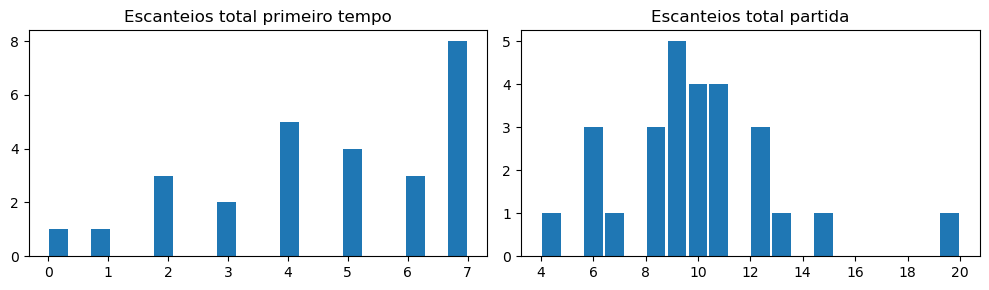

 PRIMEIRO TEMPO: 
1H 85% das partidas - de 7.5 escanteios
1H 85% das partidas + de  1.5 escanteios
1H partidas com menos de 6.5  70 % Fairline: 1.42
1H partidas com menos de 5.5  59 % Fairline: 1.69
1H partidas com menos de 4.5  44 % Fairline: 2.25
1H partidas com mais de 1.5  93 % Fairline: 1.08
1H partidas com mais de 2.5  81 % Fairline: 1.23
1H partidas com mais de 3.5  74 % Fairline: 1.35
JOGO COMPLETO: 
FT 85% das partidas - de  12.5 escanteios
FT 85% das partidas + de  5.5 escanteios
FT partidas com menos de 10.5  63 % Fairline: 1.59
FT partidas com menos de 9.5  48 % Fairline: 2.08
FT partidas com menos de 8.5  30 % Fairline: 3.38
FT partidas com mais de 6.5  85 % Fairline: 1.17
FT partidas com mais de 7.5  81 % Fairline: 1.23
FT partidas com mais de 8.5  70 % Fairline: 1.42
Partidas com saldo de escanteios positivo:  26 %
Partidas com saldo de escanteios negativo:  56 %
Partidas escanteios empatados:  19 %
Média escanteios por partida:  10
desvio padrão:  3


,first_half_corners_for,second_half_corners_for,match_corners_for,first_half_corners_against,second_half_corners_against,match_corners_against,total_match_corners,total_first_half_corners,total_second_half_corners,home_or_away,corners_balance,against
0,1,1,2,3,8,11,13,4,9,Away,-9,Newcastle
2,1,1,2,4,3,7,9,5,4,Away,-5,Arsenal
5,1,2,3,1,4,5,8,2,6,Away,-2,West Ham
8,4,4,8,3,4,7,15,7,8,Away,1,Man Utd
11,0,2,2,5,4,9,11,5,6,Away,-7,Leeds
12,0,2,2,1,7,8,10,1,9,Away,-6,Chelsea
14,2,2,4,4,0,4,8,6,2,Away,0,Brentford
15,0,1,1,4,1,5,6,4,2,Away,-4,Newcastle
19,2,2,4,2,4,6,10,4,6,Away,-2,Everton
21,0,1,1,4,4,8,9,4,5,Away,-7,Crystal Palace


In [62]:

team_id = 6
team2_id = 20 

home_name, df_home = get_corner_stats(team_id,True)
away_name, df_away = get_corner_stats(team2_id,False)


print(home_name, "Jogando em casa")
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.hist(df_home.total_first_half_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_home.total_match_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()

print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_home.total_first_half_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('1H 85% das partidas + de ', df_home.total_first_half_corners.quantile(0.15, interpolation="lower")-0.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_home.total_first_half_corners < 7).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 7).mean(),2))
print('1H partidas com menos de 5.5 ', round((df_home.total_first_half_corners < 6).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 6).mean(),2))
print('1H partidas com menos de 4.5 ', round((df_home.total_first_half_corners < 5).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 5).mean(),2))
print('1H partidas com mais de 1.5 ', round((df_home.total_first_half_corners > 1).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 1).mean(),2))
print('1H partidas com mais de 2.5 ', round((df_home.total_first_half_corners > 2).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 2).mean(),2))
print('1H partidas com mais de 3.5 ', round((df_home.total_first_half_corners > 3).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 3).mean(),2))
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_home.total_match_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('FT 85% das partidas + de ', df_home.total_match_corners.quantile(0.15,interpolation="lower")-0.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_home.total_match_corners < 11).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 11).mean(),2))
print('FT partidas com menos de 9.5 ', round((df_home.total_match_corners < 10).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 10).mean(),2))
print('FT partidas com menos de 8.5 ', round((df_home.total_match_corners < 9).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 9).mean(),2))
print('FT partidas com mais de 6.5 ', round((df_home.total_match_corners > 6).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 6).mean(),2))
print('FT partidas com mais de 7.5 ', round((df_home.total_match_corners > 7).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 7).mean(),2))
print('FT partidas com mais de 8.5 ', round((df_home.total_match_corners > 8).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 8).mean(),2))
print('Partidas com saldo de escanteios positivo: ', round((df_home.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_home.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_home.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_home.total_match_corners).mean()))
print('desvio padrão: ', round((df_home.total_match_corners).std()))
display(df_home)


print(away_name,"Jogando fora de casa")
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(df_away.total_first_half_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_away.total_match_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()
print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_away.total_first_half_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('1H 85% das partidas + de ', df_away.total_first_half_corners.quantile(0.15, interpolation="lower")-.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_away.total_first_half_corners < 7).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 7).mean(),2))
print('1H partidas com menos de 5.5 ', round((df_away.total_first_half_corners < 6).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 6).mean(),2))
print('1H partidas com menos de 4.5 ', round((df_away.total_first_half_corners < 5).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 5).mean(),2))
print('1H partidas com mais de 1.5 ', round((df_away.total_first_half_corners > 1).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 1).mean(),2))
print('1H partidas com mais de 2.5 ', round((df_away.total_first_half_corners > 2).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 2).mean(),2))
print('1H partidas com mais de 3.5 ', round((df_away.total_first_half_corners > 3).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 3).mean(),2))
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_away.total_match_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('FT 85% das partidas + de ', df_away.total_match_corners.quantile(0.15,interpolation="lower")-.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_away.total_match_corners < 11).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 11).mean(),2))
print('FT partidas com menos de 9.5 ', round((df_away.total_match_corners < 10).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 10).mean(),2))
print('FT partidas com menos de 8.5 ', round((df_away.total_match_corners < 9).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 9).mean(),2))
print('FT partidas com mais de 6.5 ', round((df_away.total_match_corners > 6).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 6).mean(),2))
print('FT partidas com mais de 7.5 ', round((df_away.total_match_corners > 7).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 7).mean(),2))
print('FT partidas com mais de 8.5 ', round((df_away.total_match_corners > 8).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 8).mean(),2))
print('Partidas com saldo de escanteios positivo: ', round((df_away.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_away.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_away.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_away.total_match_corners).mean()))
print('desvio padrão: ', round((df_away.total_match_corners).std()))
display(df_away)
